In [36]:
# !pip install transformers

In [35]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import DetectorFactory, detect_langs, detect
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel

import sklearn 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline 


In [21]:
sns.set_theme(context = 'notebook', style = 'darkgrid')

In [22]:
df = pd.read_csv(ZipFile("data/GoodReads_100k_books.csv.zip").open('GoodReads_100k_books.csv'))

In [23]:
df.head()

,author,bookformat,desc,genre,img,isbn,isbn13,link,pages,rating,reviews,title,totalratings
0,Laurence M. Hauptman,Hardcover,Reveals that several hundred thousand Indians ...,"History,Military History,Civil War,American Hi...",https://i.gr-assets.com/images/S/compressed.ph...,002914180X,9.78E+12,https://goodreads.com/book/show/1001053.Betwee...,0,3.52,5,Between Two Fires: American Indians in the Civ...,33
1,"Charlotte Fiell,Emmanuelle Dirix",Paperback,Fashion Sourcebook - 1920s is the first book i...,"Couture,Fashion,Historical,Art,Nonfiction",https://i.gr-assets.com/images/S/compressed.ph...,1906863482,9.78E+12,https://goodreads.com/book/show/10010552-fashi...,576,4.51,6,Fashion Sourcebook 1920s,41
2,Andy Anderson,Paperback,The seminal history and analysis of the Hungar...,"Politics,History",https://i.gr-assets.com/images/S/compressed.ph...,948984147,9.78E+12,https://goodreads.com/book/show/1001077.Hungar...,124,4.15,2,Hungary 56,26
3,Carlotta R. Anderson,Hardcover,"""All-American Anarchist"" chronicles the life a...","Labor,History",https://i.gr-assets.com/images/S/compressed.ph...,814327079,9.78E+12,https://goodreads.com/book/show/1001079.All_Am...,324,3.83,1,All-American Anarchist: Joseph A. Labadie and ...,6
4,Jean Leveille,NaN,"Aujourdâ€™hui, lâ€™oiseau nous invite Ã sa ta...",NaN,https://i.gr-assets.com/images/S/compressed.ph...,2761920813,NaN,https://goodreads.com/book/show/10010880-les-o...,177,4.00,1,Les oiseaux gourmands,1


<h2>Prepare Data</h2>

In [72]:
df = df.dropna(subset = ['desc', 'genre'])

In [73]:
df['genres'] = df.genre.apply(lambda s: str(s).split(","))
df['top_genre'] = df.genres.apply(lambda s: s[0])

In [26]:
df.genres.apply(len).mean(), df.genres.apply(len).median()

(9.369795870620576, 10.0)

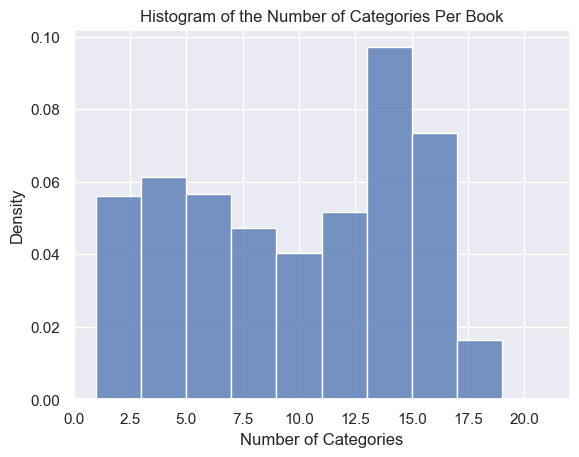

In [13]:
f = sns.histplot(df.genres.apply(len), stat = 'density', binwidth = 2)
_ = f.set(title = 'Histogram of the Number of Categories Per Book', xlabel = 'Number of Categories', 
      ylabel = 'Density')

In [14]:
df.desc.apply(len).mean(), df.desc.apply(len).median()

(878.7032812774171, 785.0)

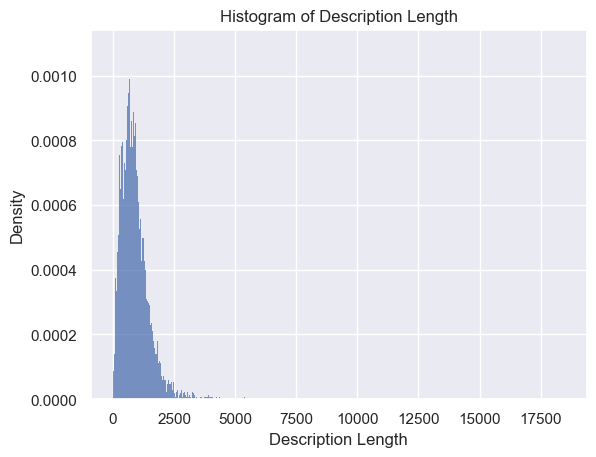

In [15]:
f = sns.histplot(df.desc.apply(len), stat = 'density', binwidth = 2)
_ = f.set(title = 'Histogram of Description Length', xlabel = 'Description Length', 
      ylabel = 'Density')

In [27]:
df[df.desc.apply(len) > 10000].desc

8086     Ù†Ø¨Ø°Ø© Ø§Ù„Ù†ÙŠÙ„ ÙˆØ§Ù„ÙØ±Ø§Øª:,Ù„Ù‚Ø¯ Ø­Ø...
8709     Two words jerked Trent Michaels out of his com...
24398    Award-winning author Charlotte Gray's latest b...
64750    What could be simpler than a single people wor...
83024    Serge Fauchereau: Prefata la Compunere cu para...
97837    Ù‡Ø°Ø§ Ø§Ù„ÙƒØªØ§Ø¨:,Ù‚Ø¨Ù„ Ø¨Ø¶Ø¹Ø© Ù‚Ø±ÙˆÙ† ...
Name: desc, dtype: object

In [28]:
# NOTE: this cell takes a long time to run!

# keep results consistent across runs
DetectorFactory.seed = 42

def get_lang(s):
    try:
        return detect(s)
    except:
        return 'unable to detect language'

df['desc_language'] = df.desc.apply(get_lang)

In [29]:
df = df[df.desc_language == 'en']

In [30]:
df.head()

,author,bookformat,desc,genre,img,isbn,isbn13,link,pages,rating,reviews,title,totalratings,genres,desc_language
0,Laurence M. Hauptman,Hardcover,Reveals that several hundred thousand Indians ...,"History,Military History,Civil War,American Hi...",https://i.gr-assets.com/images/S/compressed.ph...,002914180X,9.78E+12,https://goodreads.com/book/show/1001053.Betwee...,0,3.52,5,Between Two Fires: American Indians in the Civ...,33,"[History, Military History, Civil War, America...",en
1,"Charlotte Fiell,Emmanuelle Dirix",Paperback,Fashion Sourcebook - 1920s is the first book i...,"Couture,Fashion,Historical,Art,Nonfiction",https://i.gr-assets.com/images/S/compressed.ph...,1906863482,9.78E+12,https://goodreads.com/book/show/10010552-fashi...,576,4.51,6,Fashion Sourcebook 1920s,41,"[Couture, Fashion, Historical, Art, Nonfiction]",en
2,Andy Anderson,Paperback,The seminal history and analysis of the Hungar...,"Politics,History",https://i.gr-assets.com/images/S/compressed.ph...,948984147,9.78E+12,https://goodreads.com/book/show/1001077.Hungar...,124,4.15,2,Hungary 56,26,"[Politics, History]",en
3,Carlotta R. Anderson,Hardcover,"""All-American Anarchist"" chronicles the life a...","Labor,History",https://i.gr-assets.com/images/S/compressed.ph...,814327079,9.78E+12,https://goodreads.com/book/show/1001079.All_Am...,324,3.83,1,All-American Anarchist: Joseph A. Labadie and ...,6,"[Labor, History]",en
5,Jeffrey Pfeffer,Hardcover,Why is common sense so uncommon when it comes ...,"Business,Leadership,Romance,Historical Romance...",https://i.gr-assets.com/images/S/compressed.ph...,875848419,9.78E+12,https://goodreads.com/book/show/1001090.The_Hu...,368,3.73,7,The Human Equation: Building Profits by Puttin...,119,"[Business, Leadership, Romance, Historical Rom...",en


In [43]:
all_genres = df.explode("genres")

<h3>See Distribution of Classes</h3>

In [44]:
genre_counts = all_genres.genres.value_counts()

In [45]:
genre_counts.mean(), genre_counts.median()

(641.6666666666666, 90.0)

[Text(0.5, 1.0, 'Log Distribution'), Text(0.5, 0, 'Log Number of Occurences')]

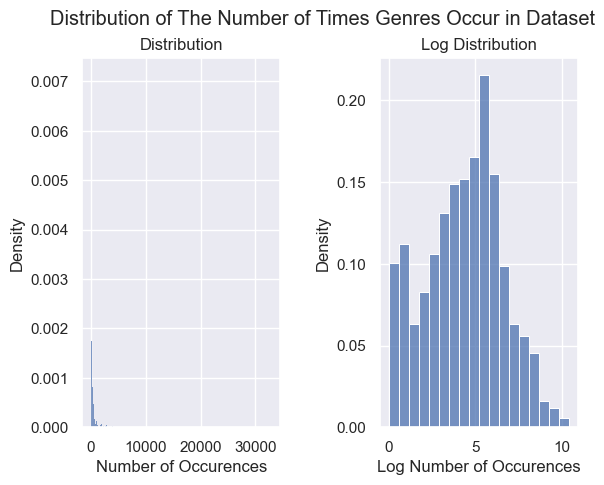

In [46]:
f, ax = plt.subplots(1, 2)
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

f1 = sns.histplot(genre_counts, stat = 'density', ax = ax[0])
f2 = sns.histplot(np.log(genre_counts), stat = 'density', ax = ax[1])

f.suptitle('Distribution of The Number of Times Genres Occur in Dataset')
f1.set(title = 'Distribution', xlabel = 'Number of Occurences')
f2.set(title = 'Log Distribution', xlabel = 'Log Number of Occurences')

<h3>Remove Uncommon Classes</h3>

In [81]:
top_genres = df.top_genre.value_counts().sort_values(ascending = False)[:100]

In [83]:
df['top_genre'] = df.top_genre.apply(lambda s: np.where(s in top_genres.index, s, 'Other'))

In [84]:
X = df.desc
y = df.top_genre

<h2>Naive Bayes Classifier</h2>

In [85]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state = 42, stratify = y) 

In [107]:
count_vect = CountVectorizer()
x_counts = count_vect.fit_transform(x_train)

x_counts.shape

(230616, 276191)

In [108]:
tf = TfidfTransformer(use_idf = False)
x_tf = tf.fit_transform(x_counts)

x_tf.shape

(230616, 276191)

In [110]:
mnb = MultinomialNB().fit(x_tf, y_train)

In [111]:
new = [['a book about a frog who falls in love'], ['once upon a time there was a frog'],
       ['frogs! in space! galatic! aliens! lasers! the frog has a laser, oh no, what will he do'], 
       ['the true story of the real horace frog a true tale of a real frog'], 
       ['my journey: after 50 years, I am finally telling my truth']]
sample_predictions = []

for i in range(len(new)):
    x_new_counts = count_vect.transform(new[i])
    x_new_tf = tf.transform(x_new_counts)
    predicted = mnb.predict(x_new_tf)
    sample_predictions.append(predicted)

In [112]:
sample_predictions

[array(['Romance'], dtype='<U19'),
 array(['Fantasy'], dtype='<U19'),
 array(['Fantasy'], dtype='<U19'),
 array(['Fantasy'], dtype='<U19'),
 array(['Romance'], dtype='<U19')]

In [113]:
x_test_counts = count_vect.transform(x_test)
x_test_tf = tf.transform(x_test_counts)
y_pred = mnb.predict(x_test_tf) 

In [131]:
outputs = pd.concat([pd.Series(y_test.values), pd.Series(y_pred)], axis = 1)
outputs.columns = ['true', 'predicted']

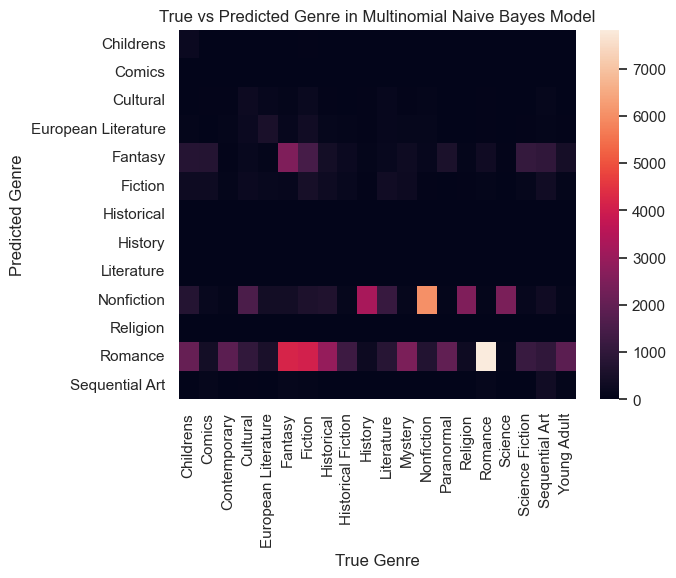

In [137]:
f = sns.heatmap(pd.crosstab(outputs.predicted, outputs.true)) 

_ = f.set(title = 'True vs Predicted Genre in Multinomial Naive Bayes Model', 
      xlabel = 'True Genre', ylabel = 'Predicted Genre')

In [116]:
print(accuracy_score(y_test, y_pred))

0.23853939015506295


<h2>BERT</h2>

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_text = tokenizer.tokenize(marked_text)